# Merging multiple spiral arms

For some of our galaxies, the clustering algorithm splits a single physical arm into multiple clusters, due to being sensitive to the length of a drawn arm. We want to merge these properly, as demonstrated in this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gzbuilderspirals import xy_from_r_theta
from gzbuilderspirals.oo import Pipeline

Define a function to generate "template" logarithmic spiral

In [3]:
t = np.linspace(1, 2*np.pi+1)

In [4]:
def log_spiral(a, b, t=t, dt=0):
    return a * np.exp(b * t), t+dt

def gen_noisy_arm_from_tpl(template, v=7):
    ltp = np.clip(np.random.randn()+1, 0, 3)
    large_scale_noise = (np.sin(ltp*template[1]) - 0.5) * np.random.randn()*v*3
    r_n = template[0] \
        + np.random.randn(len(template[0])) * v \
        + large_scale_noise
    return r_n, template[1] + np.random.randn()*0.1

Create some templates, two of which are a subset of another

In [5]:
A = 12
b = 0.4
template1 = log_spiral(A, b, t=t)
template2 = log_spiral(A, b, t=t[int(len(t) * 3/4):])
template3 = log_spiral(A, b, t=t[:int(len(t) * 2/3)])
template4 = log_spiral(A, b, t=t, dt=np.pi)

This is what our templates look like

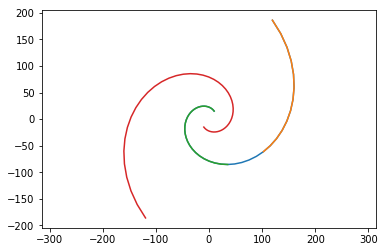

In [6]:
plt.plot(*xy_from_r_theta(*template1))
plt.plot(*xy_from_r_theta(*template2))
plt.plot(*xy_from_r_theta(*template3))
plt.plot(*xy_from_r_theta(*template4))
plt.axis('equal');

Cool, now let's make some super noisy data from each template

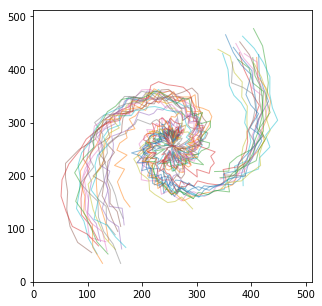

In [7]:
drawn_arms = [
    np.stack(xy_from_r_theta(*gen_noisy_arm_from_tpl(template1)), axis=1) + 256
    for i in range(8)
] + [
    np.stack(xy_from_r_theta(*gen_noisy_arm_from_tpl(template2)), axis=1) + 256
    for i in range(8)
] + [
    np.stack(xy_from_r_theta(*gen_noisy_arm_from_tpl(template3)), axis=1) + 256
    for i in range(8)
] + [
    np.stack(xy_from_r_theta(*gen_noisy_arm_from_tpl(template4)), axis=1) + 256
    for i in range(20)
]
np.random.shuffle(drawn_arms)

plt.figure(figsize=(5, 5))
for arm in drawn_arms:
    plt.plot(*arm.T, alpha=0.5, linewidth=1)
plt.xlim(0, 512); plt.ylim(0, 512);

And now use the boring `gzbuilderspirals.oo.Pipeline` class to do all the magic ✨

In [8]:
p = Pipeline(drawn_arms, phi=0, ba=1, image_size=512,
             distances=None, parallel=True, bar_length=10)

If we don't merge arms we get three overlapping segments:

In [9]:
arms = p.get_arms(merge=False)

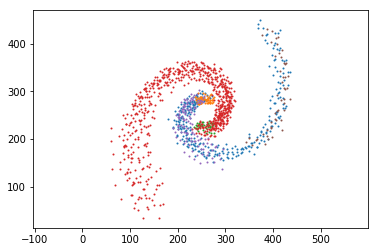

In [10]:
for arm in arms:
    plt.plot(*arm.coords[arm.outlier_mask].T, '.', markersize=2)
plt.axis('equal');

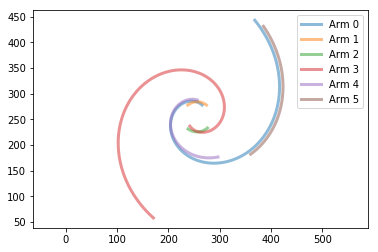

In [11]:
for i, arm in enumerate(arms):
    plt.plot(*arm.log_spiral.T, label='Arm {}'.format(i), linewidth=3, alpha=0.5)
plt.legend()
plt.axis('equal');

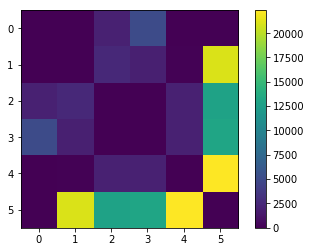

In [12]:
from gzbuilderspirals import metric
dist = np.zeros((len(arms), len(arms)))
for i in range(len(arms)):
    for j in range(i + 1, len(arms)):
        a = arms[i].log_spiral
        b = arms[j].log_spiral
        dist[i, j] =  min(
            np.sum(metric._npsdtp_vfunc(a, b)) / len(a),
            np.sum(metric._npsdtp_vfunc(b, a)) / len(b),
        )
dist += dist.T
plt.imshow(dist)
plt.colorbar();

Merging makes things much nicer!

In [13]:
# can also accomplish by arms = p.get_arms(), merging defaults to True
merged_arms = p.merge_arms(arms)

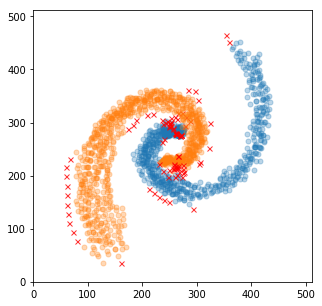

In [14]:
plt.figure(figsize=(5, 5))
for arm in merged_arms:
    plt.plot(*arm.coords[arm.outlier_mask].T, '.', markersize=10, alpha=0.3)
    plt.plot(*arm.coords[~arm.outlier_mask].T, 'rx', markersize=5, alpha=0.8)
plt.xlim(0, 512); plt.ylim(0, 512);

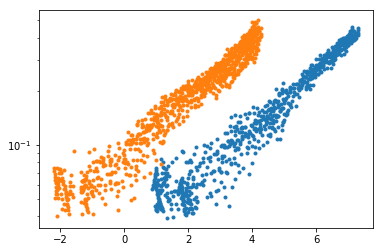

In [15]:
for arm in merged_arms:
    plt.plot(arm.t, arm.R, '.')
plt.yscale('log')

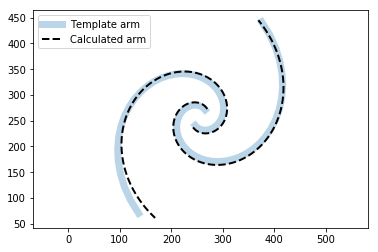

In [16]:
plt.plot(*np.array(xy_from_r_theta(*template1)) + 256, 'C0', linewidth=7, alpha=0.3)
plt.plot(*np.array(xy_from_r_theta(*template4)) + 256, 'C0', linewidth=7, alpha=0.3)
for i, arm in enumerate(merged_arms):
    plt.plot(*arm.log_spiral.T, 'k--', linewidth=2, alpha=1)
plt.plot([], [], 'C0', linewidth=7, alpha=0.3, label='Template arm')
plt.plot([], [], 'k--', linewidth=2, alpha=1, label='Calculated arm')
plt.legend()
plt.axis('equal');

And the resulting pitch angle we calculate is...

In [17]:
pa, spa = p.get_pitch_angle(merged_arms)
print('Actual pitch angle: {:.2f}'.format(
    90 - np.rad2deg(np.arctan(np.abs(1/0.4)))
))
print('Recovered pitch angle: {:.2f} ± {:.4f}'.format(
    pa, spa,
))

Actual pitch angle: 21.80
Recovered pitch angle: 19.31 ± 2.2380


In [18]:
_, scores0 = merged_arms[0].fit_polynomials()
_, scores1 = merged_arms[1].fit_polynomials()
avg_scores = (pd.DataFrame(scores0).mean(axis=0) + pd.DataFrame(scores1).mean(axis=0)) / 2
avg_scores

poly_spiral_1   -0.034796
poly_spiral_2   -0.017805
poly_spiral_3   -0.016445
poly_spiral_4   -0.015907
log_spiral      -0.015834
dtype: float64

### And now to attempt on real data!

Read in the data using some helper functions

In [19]:
import lib.galaxy_utilities as gu
sid = 20901996
drawn_arms_gal = gu.get_drawn_arms(sid, gu.classifications)
gal, angle = gu.get_galaxy_and_angle(sid)
pic_array, _ = gu.get_image(gal, sid, angle)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Same pipeline process as before

In [20]:
p_gal = Pipeline(drawn_arms_gal, phi=angle, ba=gal['PETRO_BA90'],
             image_size=512, distances=None, parallel=True)
arms_gal = p_gal.get_arms(merge=False)
merged_arms_gal = p_gal.merge_arms(arms_gal)

Let's see what we're dealing with 👀

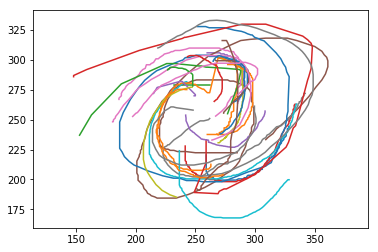

In [21]:
for arm in drawn_arms_gal:
    plt.plot(*arm.T)
plt.axis('equal');

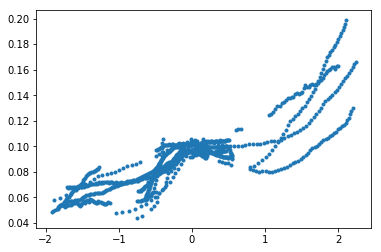

In [22]:
for arm in merged_arms_gal:
    plt.plot(arm.t, arm.R, '.')
# plt.yscale('log')

Well it's a bit of a mess... let's see what the code makes of it!

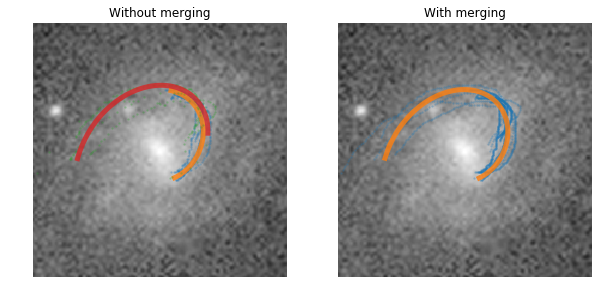

In [23]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))
plt.sca(ax0)
plt.imshow(pic_array, cmap='gray', origin='lower')
for arm in arms_gal:
    plt.plot(*arm.coords.T, '.', markersize=3, alpha=0.2)
    plt.plot(*arm.reprojected_log_spiral.T, linewidth=5, alpha=0.8)
plt.axis('off');
plt.xlim(150, 512-150);
plt.ylim(150, 512-150);
plt.title('Without merging')

plt.sca(ax1)
plt.imshow(pic_array, cmap='gray', origin='lower')
for arm in merged_arms_gal:
    plt.plot(*arm.coords.T, '.', markersize=3, alpha=0.2)
    plt.plot(*arm.reprojected_log_spiral.T, linewidth=5, alpha=0.8)
plt.axis('off')
plt.xlim(150, 512-150)
plt.ylim(150, 512-150)
plt.title('With merging');